### Trying PyDeconv on simulations

In [134]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import mne
from pydeconv.utils import *
from pydeconv.pydeconv_sims import *
from pydeconv import *
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
%matplotlib qt 


# raw     = mne.io.read_raw_eeglab(data_path + "629959_analysis.set", preload=True)

# # Initialize the model

# rERP_model = PyDeconv(settings = settings , features = features, eeg = raw)
# X_design = rERP_model.create_matrix()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
#A VERY SIMPLE DISTRIBUTION WITH SMALL OVERLAP
# sig = EEGSimulator(200, 500)
# W_matrix = [[1]]
# kernels = {
#             0: {'onsets': [0, 0.19, 0.25], 'amplitudes': [0.1, -0.05, 0.04], 'widths': [0.05, 0.05, 0.07], 'weight':0.3},
#             'modulation': {'ker_idx2mod': 1, 'mod': 'linear','dist': 'uniform', 'lims': [100, 600]}
#         }

# sig.create_isi_pdf(0, sample_size=100, lims=[.3, 1], dist_type='skewed', mode=.50, skew=0, scale=.5)


sig = EEGSimulator(1000, 500)
# transition probabilities
W_matrix = [[0, 0.45, 0.45, 0.1],[0.9, 0, 0 , .1],[0.9, 0, 0,.1], [.33,.33,.33,0]]
kernels = {
            0: {'onsets': [0, 0.19, 0.25], 'amplitudes': [0.1, -0.05, 0.04], 'widths': [0.05, 0.05, 0.07], 'weight':0.3},
            1: {'onsets': [0, 0.19, 0.25], 'amplitudes': [0.1, -0.05, 0.04], 'widths': [0.05, 0.05, 0.07], 'weight':0.3},
            2: {'onsets': [0, 0.19, 0.25], 'amplitudes': [0.1, -0.07, 0.04], 'widths': [0.05, 0.05, 0.07], 'weight':0.3},
            3: {'onsets': [0, 0.19, 0.25], 'amplitudes': [0.1, -0.07, 0.04], 'widths': [0.05, 0.05, 0.07], 'weight':0.3},
            'modulation': {'ker_idx2mod': 1, 'mod': 'linear','dist': 'uniform', 'lims': [100, 600]}
        }

sig.create_isi_pdf(0, sample_size=100, lims=[.01, .15], dist_type='skewed', mode=.05, skew=0, scale=.01)
sig.create_isi_pdf(1, sample_size=100, lims=[.1, .6], dist_type='skewed', mode=.3, skew=2, scale=.05)
sig.create_isi_pdf(2, sample_size=100, lims=[.1, .6], dist_type='skewed', mode=.3, skew=2, scale=.05)
sig.create_isi_pdf(3, sample_size=100, lims=[.1, .6], dist_type='uniform')


# sig.combine_isi_pdf
# sig.plot_isi_pdf(0)
# sig.plot_isi_pdf(1)


sig.simulate(noise=None,erp_ker=kernels,w_matrix=W_matrix)
sig.plot_response_idx(0)
sig.plot_response_idx(1)
sig.plot_response_idx(2)
plt.show()
sig.plot_datanpsd()
sig.data_stats()
plt.show()


No noise added
None ISI params for kernel 1
None ISI params for kernel 2
Mean:    0.1708075140091042 
Median:    0.04422024203154425
Variance:  0.12002623886189427


In [157]:
# Simulating the histogram plot for the latencies difference in a separate window
plt.figure()
sig.evts['latency'].diff().hist(bins=50)
plt.title("Histogram of Latency Differences")
plt.xlabel("Latency Differences (ms)")
plt.ylabel("Frequency")
plt.show()


In [160]:
import numpy as np

# Copy and modify the event data
evts = sig.evts.copy()

# Set the event type to filter (event_id 1 for example)
event_id1 = 1
event_id2 = 2

# Filter events where `type == event_id`
filtered_evts = evts.loc[(evts['type'] == event_id1) | (evts['type'] == event_id2)]

# Get the number of filtered events
n_events = len(filtered_evts)

# Ensure that latencies are integer values
latencies = filtered_evts['latency'].values.astype(int)

# Create the events array for MNE
# Column 1: Latencies
# Column 2: Zeros (assuming no previous event values, hence zeros)
# Column 3: Event types (all set to 1 since filtered for `event_id`)
mne_events = np.column_stack((latencies,
                              np.zeros(n_events, dtype=int),
                              np.ones(n_events, dtype=int)))

# Print or use `mne_events` as needed
print(mne_events[:5])


[[   0    0    1]
 [ 324    0    1]
 [ 847    0    1]
 [ 905    0    1]
 [1134    0    1]]


In [150]:
import mne

# Parameters
n_seconds = 1000        # Duration of the signal in seconds
sfreq = 500            # Sampling frequency in Hz
n_samples = n_seconds * sfreq  # Total number of samples
n_channels = 1         # Number of channels (virtual channel)

# Create random data for the virtual channel (shape: [n_samples])
data = sig.data

# Reshape the data to be 2D (n_channels, n_samples)
data = data.reshape((n_channels, n_samples))

# Create MNE info object
ch_names = ['VirtualEEG']  # Name of the virtual channel
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')

# Create the Raw object from the reshaped data array
raw = mne.io.RawArray(data, info)




Creating RawArray with float64 data, n_channels=1, n_times=500000
    Range : 0 ... 499999 =      0.000 ...   999.998 secs
Ready.


Not setting metadata
563 matching events found
Setting baseline interval to [-0.3, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 563 events and 501 original time points ...
1 bad epochs dropped
Need more than one channel to make topography for eeg. Disabling interactivity.


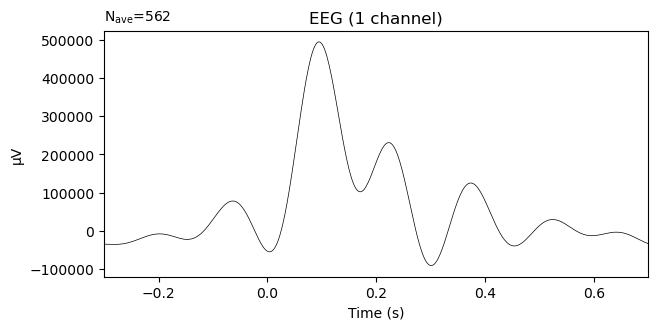

In [151]:
epochs = mne.Epochs(raw, mne_events,  tmin=-0.3, tmax=0.7, preload=True, event_repeated='drop')
evk = epochs.average()
evk.plot()


In [140]:
evts

,latency,type,categorical,continuous
0,0.000000,0,NaN,NaN
1,5.776875,3,NaN,NaN
2,105.275509,2,NaN,NaN
3,189.363814,0,NaN,NaN
4,188.519356,2,NaN,NaN
...,...,...,...,...
1195,60780.411285,0,NaN,NaN
1196,60788.101861,1,NaN,NaN
1197,60883.099284,0,NaN,NaN
1198,60890.906651,1,NaN,NaN


In [161]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_samples_per_epoch = 300# Number of samples per epoch
sfreq = 500  # Sampling frequency (Hz)

# EEG data (replace with actual data from sig object)
data = sig.data  # Assuming data is a NumPy array (could be 1D or 2D)

# Ensure data is 2D (shape: [n_channels, n_samples])
if data.ndim == 1:
    data = data[np.newaxis, :]  # Convert to shape (1, n_samples) if 1D

n_channels, n_samples = data.shape

# Latencies (in sample indices, from mne_events)
latencies_samples = mne_events[:, 0].astype(int)  # Convert latencies to integer indices

# Prepare to store epochs
epochs = []

# Extract epochs (1000 samples per epoch starting at each latency)
for latency in latencies_samples:
    # Make sure we don't go out of bounds
    if latency + n_samples_per_epoch <= n_samples:
        # Extract epoch data for all channels
        epoch = data[:, latency:latency + n_samples_per_epoch]
        epochs.append(epoch)

# Convert epochs list to a NumPy array (shape: [n_epochs, n_channels, n_samples_per_epoch])
epochs = np.array(epochs)

# Average across epochs to get ERP (shape: [n_channels, n_samples_per_epoch])
erp = np.mean(epochs, axis=0)

# Plot the ERP (time-locked averaged signal for the first channel)
time = np.arange(n_samples_per_epoch) / sfreq * 1000  # Time in milliseconds
plt.plot(time, erp[0, :])  # Plotting the ERP for the first channel
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (µV)')
plt.title('ERP Response - Channel 1')
plt.show()


In [146]:

# Plot vertical lines at these positions
plt.figure(figsize=(8, 4))
for onset in sig.onsets:
    plt.axvline(x=onset, color='r', linestyle='--')
plt.plot(sig.data)

plt.title('Onset Positions')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.show()

In [143]:
evts['type'].value_counts()

# Update 'effect' column
evts['effect'] = evts['type'].apply(lambda x: True if x == 2 else False if x == 1 else np.nan)

# Replace all 2s with 1s in 'type' column
evts['type'] = evts['type'].replace(2, 1)
evts['type'].value_counts()
columns = {'latencies':latency,	'type':'type','categorical':'categorical','continuous':'continuous'}
# evts.rename(columns=columns, inplace=True)


In [144]:
evts

,latency,type,categorical,continuous,effect
0,0.000000,0,NaN,NaN,NaN
1,5.776875,3,NaN,NaN,NaN
2,105.275509,1,NaN,NaN,True
3,189.363814,0,NaN,NaN,NaN
4,188.519356,1,NaN,NaN,True
...,...,...,...,...,...
1195,60780.411285,0,NaN,NaN,NaN
1196,60788.101861,1,NaN,NaN,False
1197,60883.099284,0,NaN,NaN,NaN
1198,60890.906651,1,NaN,NaN,False


## Deconvolution

In [145]:

# Load parameter, data and features
#==================================
import config4test
settings = analyze_data(config4test)
features = evts
# raw     = raw
# Initialize the model
#=====================
rERP_model = PyDeconv(settings = settings , features = features, eeg = raw)
X_design = rERP_model.create_matrix()
y_data   = rERP_model.get_nonzero_data()

# Model Selection 
#================
solver = rERP_model.estimator
num_folds = 5
alphas = np.linspace(5, 500, 20)
param_grid = {'alpha': alphas.tolist()}
# Create StratifiedKFold object
kf = KFold(n_splits=num_folds)
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=solver, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=kf,verbose=5)
grid_search.fit(X_design, y_data)
# rERP_model.estimator.set_params(alpha = 24)
# rERP_model.fit(X_design, y_data)

# # Extract results
# #================
cv_results = grid_search.cv_results_
best_model = grid_search.best_estimator_
rERP_model.coef_ = best_model.coef_

# fig = rERP_model.plot_coefs()

# rERP_model.coef_.shape
rERP_model.plot_coefs(top_topos=False)
plt.show()


Analyzing data with model: testingSims
Time range: -0.2 to 0.6
Solver: ridge

Model Name: testingSims
First Intercept Event Type: 1
Second Intercept Event Type: 0
Sampling Frequency: 500.0
Time Window: -0.2 to 0.6
Channels to Analyze: 1

Model Description:
Intercept: True
Additive Features: ['effect']
Interactions: None


Original Design Matrix Shape:
X_design shape: (500000, 1203)
y_data shape: (500000, 1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........................alpha=5.0;, score=-0.048 total time=   0.0s
[CV 2/5] END ........................alpha=5.0;, score=-0.063 total time=   0.0s
[CV 3/5] END ........................alpha=5.0;, score=-0.051 total time=   0.0s
[CV 4/5] END ........................alpha=5.0;, score=-0.051 total time=   0.0s
[CV 5/5] END ........................alpha=5.0;, score=-0.050 total time=   0.0s
[CV 1/5] END ..........alpha=31.05263157894737;, score=-0.055 total time=   0.0s
[CV 2/5] END ..........alpha=31.05263157

In [152]:
plt.plot(sig.data)

In [155]:
features['latency']

0           0.000000
1           5.776875
2         105.275509
3         189.363814
4         188.519356
            ...     
1195    60780.411285
1196    60788.101861
1197    60883.099284
1198    60890.906651
1199    60963.657358
Name: latency, Length: 1200, dtype: float64